# Ema & candlestick - Strategy - Backtesting 

### Import Library

In [2]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')
# from backtesting._plotting import set_bokeh_output
# set_bokeh_output(notebook=False)
from backtesting import set_bokeh_output
set_bokeh_output(notebook=False)

### Load Price Data

In [3]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [4]:
data = dataset.copy()

In [5]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2020-11-01 00:00:00']

In [6]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2024-11-28 14:15:00,1306.1,1307.3,1305.6,1306.9,7726
2024-11-28 14:20:00,1306.9,1307.6,1306.0,1307.6,5086
2024-11-28 14:25:00,1307.6,1308.6,1307.4,1307.9,7291


In [7]:
def get_signal(r):
    signal = ''
    if r['ema_fast_s1'] < r['ema_low_s1'] and r['ema_fast'] > r['ema_low']:
        signal = 'long'
    elif r['ema_fast_s1'] > r['ema_low_s1'] and r['ema_fast'] < r['ema_low']:
        signal = 'short'
    else:
        if r['ema_fast'] > r['ema_low']:
            if r['Close'] == r['High']:
                signal = 'long'
        if r['ema_fast'] < r['ema_low']:
            if r['Close'] == r['Low']:
                signal = 'short'
    return signal

In [8]:
def prepare_data(data):
    #
    data["current"] = data.index + pd.DateOffset(minutes=5)
    #
    data['max_in_range'] = data['High'].rolling(10).max()
    data['min_in_range'] = data['Low'].rolling(10).min()
    data["ema_fast"] = ta.ema(data["Close"], length=20)
    data["ema_low"] = ta.ema(data["Close"], length=250)
    data['ema_fast_s1'] = data['ema_fast'].shift(1)
    data['ema_low_s1'] = data['ema_low'].shift(1)
    data['signal'] = data.apply(lambda r: get_signal(r), axis=1)
    # Optimnize
    data['RSI'] = ta.rsi(data["Close"], length=14)
    data['body'] = data.apply(lambda r: abs(r['Close'] - r['Open']), axis=1)
    data['ibs'] = data.apply(lambda x: (-10 if (x["High"] == x["Low"]) else 10 * (x["Close"] - x["Low"]) / (x["High"] - x["Low"])), axis=1)
    data["vol_20_mean"] = data["Volume"].rolling(20).mean()
    data['prev_body'] = data['body'].shift(1)
    data['next_body'] = data['body'].shift(-1)
    return data

In [9]:
prepared_data = prepare_data(data)
prepared_data.dropna(inplace=True)

In [10]:
prepared_data

,Open,High,Low,Close,Volume,current,max_in_range,min_in_range,ema_fast,ema_low,ema_fast_s1,ema_low_s1,signal,RSI,body,ibs,vol_20_mean,prev_body,next_body
Date,,,,,,,,,,,,,,,,,,,
2020-11-06 14:15:00,911.0,912.7,910.5,910.6,5948,2020-11-06 14:20:00,912.7,903.5,907.880896,908.796883,907.594675,908.782400,,59.952872,0.4,0.454545,3106.55,3.0,0.2
2020-11-06 14:20:00,910.7,911.2,909.4,910.9,4466,2020-11-06 14:25:00,912.7,903.5,908.168430,908.813641,907.880896,908.796883,,60.883966,0.2,8.333333,3207.00,0.4,0.5
2020-11-06 14:25:00,910.5,911.0,908.5,910.0,3602,2020-11-06 14:30:00,912.7,904.4,908.342865,908.823094,908.168430,908.813641,,56.630178,0.5,6.000000,3146.40,0.2,0.2
2020-11-06 14:30:00,910.5,910.7,910.5,910.7,78,2020-11-06 14:35:00,912.7,906.2,908.567354,908.838049,908.342865,908.823094,,59.027913,0.2,10.000000,2973.85,0.5,0.0
2020-11-06 14:45:00,908.3,908.3,908.3,908.3,4462,2020-11-06 14:50:00,912.7,906.7,908.541892,908.833762,908.567354,908.838049,short,49.021125,0.0,-10.000000,3193.20,0.2,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-28 14:10:00,1305.8,1306.6,1305.2,1306.3,8590,2024-11-28 14:15:00,1311.1,1305.2,1309.572557,1302.797698,1309.917037,1302.769567,,33.516628,0.5,7.857143,3491.20,2.8,0.8
2024-11-28 14:15:00,1306.1,1307.3,1305.6,1306.9,7726,2024-11-28 14:20:00,1311.1,1305.2,1309.318028,1302.830386,1309.572557,1302.797698,,36.878302,0.8,7.647059,3759.80,0.5,0.7
2024-11-28 14:20:00,1306.9,1307.6,1306.0,1307.6,5086,2024-11-28 14:25:00,1311.1,1305.2,1309.154406,1302.868391,1309.318028,1302.830386,long,40.648838,0.7,10.000000,3891.45,0.8,0.3


In [11]:
prepared_data[prepared_data.signal != ''].tail(20)

,Open,High,Low,Close,Volume,current,max_in_range,min_in_range,ema_fast,ema_low,ema_fast_s1,ema_low_s1,signal,RSI,body,ibs,vol_20_mean,prev_body,next_body
Date,,,,,,,,,,,,,,,,,,,
2024-11-25 13:40:00,1295.7,1297.4,1295.6,1297.4,3080,2024-11-25 13:45:00,1298.8,1294.9,1296.985067,1286.652262,1296.941390,1286.565935,long,52.055849,1.7,10.0,3126.40,0.9,0.7
2024-11-25 14:30:00,1297.1,1297.1,1297.1,1297.1,161,2024-11-25 14:35:00,1300.9,1295.9,1297.283010,1287.489520,1297.302274,1287.412327,long,49.314332,0.0,-10.0,3963.90,1.0,0.0
2024-11-25 14:45:00,1298.4,1298.4,1298.4,1298.4,5627,2024-11-25 14:50:00,1300.9,1295.9,1297.389390,1287.576456,1297.283010,1287.489520,long,54.778494,0.0,-10.0,4243.35,0.0,1.4
2024-11-26 09:10:00,1298.2,1301.5,1298.1,1301.5,6906,2024-11-26 09:15:00,1301.5,1295.9,1297.859348,1287.849193,1297.476122,1287.739548,long,64.243469,3.3,10.0,4559.05,0.7,1.9
2024-11-26 09:25:00,1303.5,1305.4,1303.5,1305.4,6758,2024-11-26 09:30:00,1305.4,1296.1,1299.495505,1288.234698,1298.873979,1288.096824,long,72.816157,1.9,10.0,4958.55,0.2,0.2
2024-11-26 10:35:00,1310.8,1311.2,1309.3,1311.2,3693,2024-11-26 10:40:00,1311.2,1304.2,1305.768550,1290.229788,1305.196818,1290.061352,long,78.429020,0.4,10.0,4816.45,1.6,0.2
2024-11-26 11:15:00,1309.0,1309.5,1308.9,1309.5,1160,2024-11-26 11:20:00,1311.3,1308.6,1307.885144,1291.436386,1307.715159,1291.291297,long,65.177514,0.5,10.0,3399.45,0.3,0.8
2024-11-26 11:30:00,1310.3,1310.5,1310.3,1310.5,45,2024-11-26 11:35:00,1310.9,1308.6,1308.530526,1291.885319,1308.323213,1291.735804,long,68.825995,0.2,10.0,3204.35,0.1,0.2
2024-11-26 13:40:00,1308.8,1309.2,1308.5,1309.2,2396,2024-11-26 13:45:00,1311.9,1308.3,1309.060597,1293.108536,1309.045923,1292.979287,long,54.799607,0.4,10.0,2501.05,0.2,1.1


In [12]:
class MainStrategy(Strategy):
    max_sl = 3.1
    trailing_sl = 7
    tp_step = 27
    def init(self):
        self._broker._cash = 1500
        super().init()

    def next(self):
        super().next()
        close_price = self.data.Close[-1]
        if self.position.is_long:
            max_in_range = self.data.max_in_range[-1]
            if close_price < max_in_range - self.trailing_sl:
                self.position.close()
        elif self.position.is_short:
            min_in_range = self.data.min_in_range[-1]
            if close_price > min_in_range + self.trailing_sl:
                self.position.close()
 
        signal = self.data.signal[-1]
        if self.position:
            if signal == 'long' and self.position.is_short:
                self.position.close()
                buy_price = close_price
                sl = buy_price - self.max_sl
                tp = buy_price + self.tp_step
                self.buy(size=1, sl=sl, tp=tp)
            elif signal == 'short' and self.position.is_long:
                sell_price = close_price
                self.position.close()
                sl = sell_price + self.max_sl
                tp = sell_price - self.tp_step
                self.sell(size=1, sl=sl, tp=tp)
        else:
            if signal == 'long':
                buy_price = close_price
                sl = buy_price - self.max_sl
                tp = buy_price + self.tp_step
                self.buy(size=1, sl=sl, tp=tp)
            elif signal == 'short':
                sell_price = close_price
                sl = sell_price + self.max_sl
                tp = sell_price - self.tp_step
                self.sell(size=1, sl=sl, tp=tp)

In [13]:
bt = Backtest(prepared_data, MainStrategy, commission=.0003, exclusive_orders=True)
stats = bt.run()

In [14]:
stats

Start                     2020-11-06 14:15:00
End                       2024-11-28 14:30:00
Duration                   1483 days 00:15:00
Exposure Time [%]                   72.265429
Equity Final [$]                   2079.53575
Equity Peak [$]                    2092.02106
Return [%]                          38.635717
Buy & Hold Return [%]                43.60861
Return (Ann.) [%]                    8.448655
Volatility (Ann.) [%]               10.365953
Sharpe Ratio                         0.815039
Sortino Ratio                         1.44642
Calmar Ratio                         0.377782
Max. Drawdown [%]                  -22.363817
Avg. Drawdown [%]                   -0.389752
Max. Drawdown Duration     1263 days 20:00:00
Avg. Drawdown Duration        7 days 17:42:00
# Trades                                 2313
Win Rate [%]                        28.102032
Best Trade [%]                       6.210947
Worst Trade [%]                     -3.099416
Avg. Trade [%]                    

In [15]:
stats['_trades'].tail(20)

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
2293,-1,51071,51072,1307.60760,1310.8,-3.19240,-0.002441,2024-11-12 14:00:00,2024-11-12 14:05:00,None,0 days 00:05:00
2294,-1,51073,51079,1306.90781,1305.7,1.20781,0.000924,2024-11-12 14:10:00,2024-11-13 09:00:00,None,0 days 18:50:00
2295,-1,51093,51121,1306.70787,1306.3,0.40787,0.000312,2024-11-13 10:10:00,2024-11-13 13:55:00,None,0 days 03:45:00
2296,-1,51125,51127,1307.70757,1309.6,-1.89243,-0.001447,2024-11-13 14:15:00,2024-11-13 14:25:00,None,0 days 00:10:00
2297,-1,51129,51145,1306.90781,1308.5,-1.59219,-0.001218,2024-11-13 14:45:00,2024-11-14 10:15:00,None,0 days 19:30:00
2298,-1,51147,51207,1306.70787,1280.2,26.50787,0.020286,2024-11-14 10:25:00,2024-11-15 11:10:00,None,1 days 00:45:00
2299,-1,51212,51217,1280.71567,1284.2,-3.48433,-0.002721,2024-11-15 13:00:00,2024-11-15 13:25:00,None,0 days 00:25:00
2300,-1,51228,51228,1277.91651,1280.9,-2.98349,-0.002335,2024-11-15 14:20:00,2024-11-15 14:20:00,None,0 days 00:00:00
2301,-1,51231,51273,1275.21732,1268.8,6.41732,0.005032,2024-11-15 14:45:00,2024-11-18 13:50:00,None,2 days 23:05:00
2302,-1,51275,51276,1271.31849,1272.5,-1.18151,-0.000929,2024-11-18 14:00:00,2024-11-18 14:05:00,None,0 days 00:05:00


In [16]:
stats['_trades']['PnL'].min()

-39.885949999999866

In [17]:
trades = stats['_trades']

In [18]:
trades[trades.PnL < -3.1]

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
4,1,115,148,921.17627,917.8,-3.37627,-0.003665,2020-11-11 09:40:00,2020-11-11 13:50:00,None,0 days 04:10:00
5,-1,153,154,912.32622,915.7,-3.37378,-0.003698,2020-11-11 14:15:00,2020-11-11 14:20:00,None,0 days 00:05:00
10,-1,311,343,919.32412,922.7,-3.37588,-0.003672,2020-11-17 09:10:00,2020-11-17 13:15:00,None,0 days 04:05:00
11,-1,349,353,923.62283,927.1,-3.47717,-0.003765,2020-11-17 13:45:00,2020-11-17 14:05:00,None,0 days 00:20:00
17,-1,829,851,962.71110,965.9,-3.18890,-0.003312,2020-12-01 09:50:00,2020-12-01 13:05:00,None,0 days 03:15:00
...,...,...,...,...,...,...,...,...,...,...,...
2299,-1,51212,51217,1280.71567,1284.2,-3.48433,-0.002721,2024-11-15 13:00:00,2024-11-15 13:25:00,None,0 days 00:25:00
2305,-1,51372,51372,1275.81714,1279.3,-3.48286,-0.002730,2024-11-20 13:35:00,2024-11-20 13:35:00,None,0 days 00:00:00
2307,-1,51411,51417,1268.11945,1271.7,-3.58055,-0.002824,2024-11-21 11:10:00,2024-11-21 13:05:00,None,0 days 01:55:00
2308,-1,51427,51430,1275.11735,1278.6,-3.48265,-0.002731,2024-11-21 13:55:00,2024-11-21 14:10:00,None,0 days 00:15:00


In [19]:
trades[trades.PnL < -3.1]['PnL'].sum()

-4327.443889999893

In [20]:
len(trades[trades.PnL < -3.1]) * -3.1

-3155.8

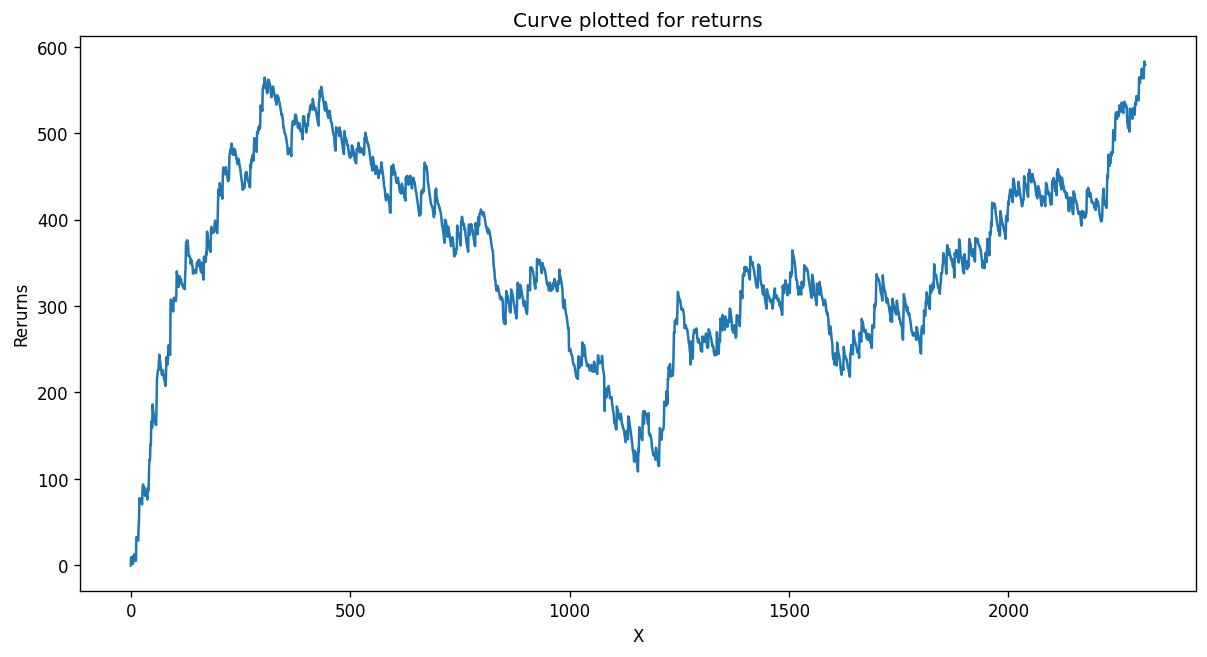

In [21]:
copy_trades = trades.copy()
copy_trades['cum_sum'] = copy_trades['PnL'].cumsum()
X = np.array(range(0, len(copy_trades['cum_sum'])))
Y = copy_trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()

## Trades Analytics

In [62]:
join_trades = pd.merge(trades, prepared_data, left_on="EntryTime", right_on='current', how="left")
join_trades

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,...,ema_low,ema_fast_s1,ema_low_s1,signal,RSI,body,ibs,vol_20_mean,prev_body,next_body
0,1,6,104,915.07444,924.6,9.52556,0.010410,2020-11-09 09:05:00,2020-11-10 14:25:00,None,...,908.879708,908.541892,908.833762,long,65.537071,0.4,5.714286,3253.15,0.0,0.2
1,-1,153,154,912.32622,915.7,-3.37378,-0.003698,2020-11-11 14:15:00,2020-11-11 14:20:00,None,...,918.540744,918.604138,918.588461,short,28.994032,2.6,0.000000,3301.00,1.5,0.9
2,1,158,285,921.67642,930.7,9.02358,0.009790,2020-11-12 09:00:00,2020-11-16 11:15:00,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1,309,309,919.12418,920.0,-0.87582,-0.000953,2020-11-17 09:00:00,2020-11-17 09:00:00,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,356,409,932.47966,933.0,0.52034,0.000558,2020-11-17 14:20:00,2020-11-18 14:30:00,None,...,925.322347,924.798616,925.267105,long,83.695941,1.0,8.235294,2924.90,2.3,1.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,1,50661,50671,1344.30317,1340.4,-3.90317,-0.002903,2024-10-31 13:50:00,2024-11-01 09:00:00,None,...,1338.968548,1338.574059,1338.929741,long,72.381292,1.3,5.161290,4331.95,3.1,0.3
341,-1,50682,50825,1336.79884,1324.9,11.89884,0.008901,2024-11-01 09:55:00,2024-11-06 09:05:00,None,...,1339.242278,1339.399978,1339.257879,short,40.684472,0.3,8.000000,4679.85,0.5,0.9
342,1,50863,50884,1332.09951,1336.3,4.20049,0.003153,2024-11-06 13:40:00,2024-11-07 09:45:00,None,...,1328.212243,1327.918487,1328.184229,long,77.750055,0.7,6.400000,3632.00,0.1,0.1
343,-1,50954,51021,1327.60160,1313.8,13.80160,0.010396,2024-11-08 11:20:00,2024-11-11 14:05:00,None,...,1332.634868,1333.073749,1332.669686,short,23.968700,0.7,3.125000,3505.20,0.8,0.3


In [63]:
long_trades = join_trades[join_trades.Size==1]
short_trades = join_trades[join_trades.Size==-1]

Text(0, 0.5, 'PnL')

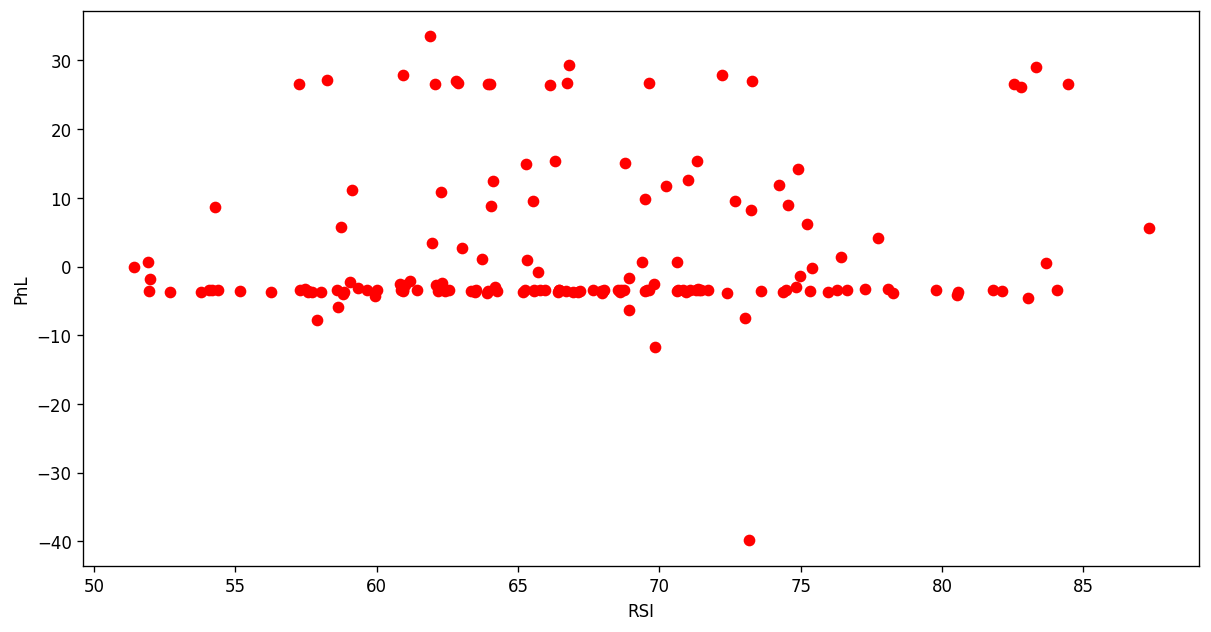

In [64]:
plt.scatter(long_trades['RSI'], long_trades['PnL'], color='red')
plt.xlabel("RSI")
plt.ylabel("PnL")

Text(0, 0.5, 'PnL')

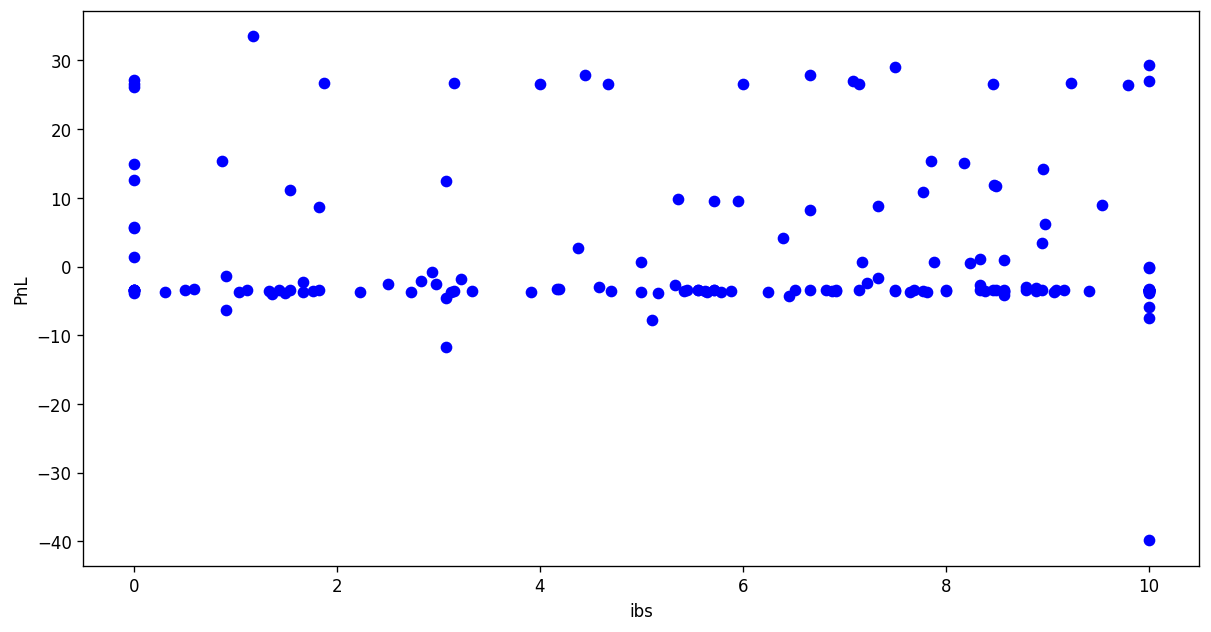

In [65]:
plt.scatter(long_trades['ibs'], long_trades['PnL'], color='blue')
plt.xlabel("ibs")
plt.ylabel("PnL")

Text(0, 0.5, 'PnL')

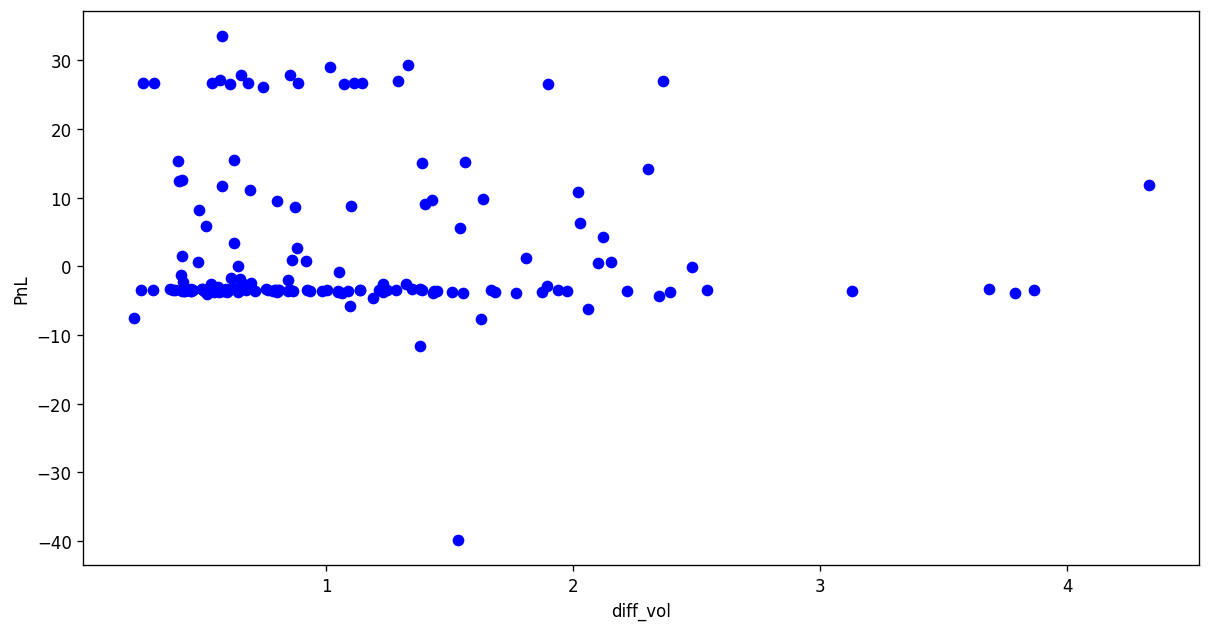

In [66]:
long_trades['diff_vol'] = long_trades['Volume'] / long_trades['vol_20_mean']
plt.scatter(long_trades['diff_vol'], long_trades['PnL'], color='blue')
plt.xlabel("diff_vol")
plt.ylabel("PnL")

Text(0, 0.5, 'PnL')

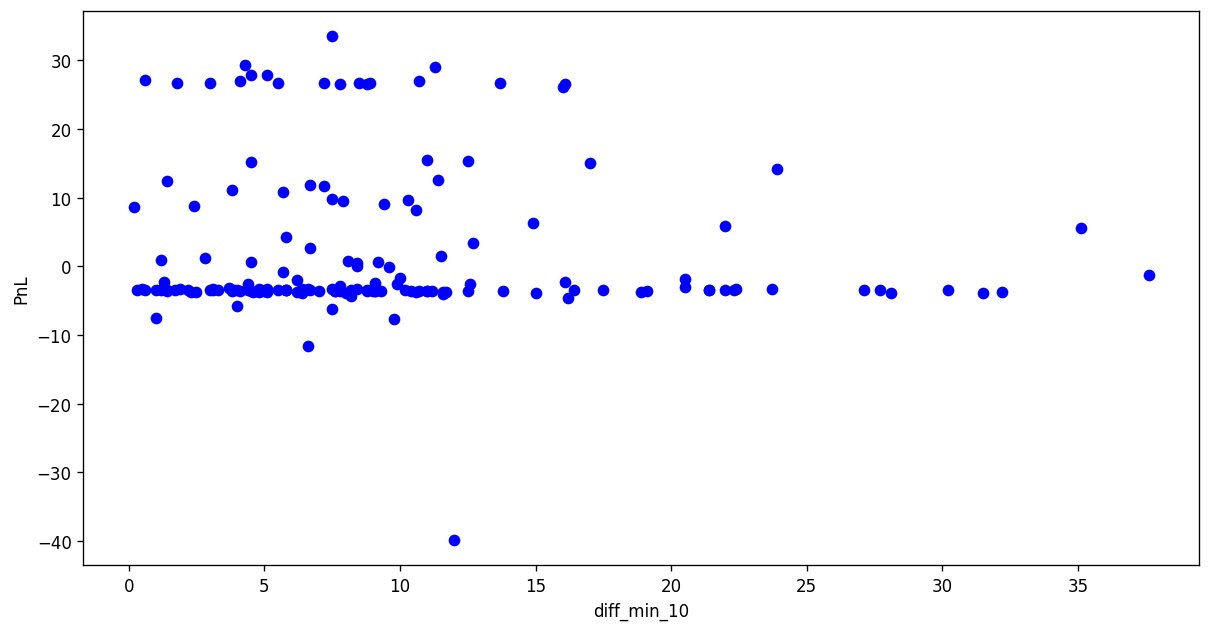

In [67]:
long_trades['diff_min_10'] = long_trades['Close'] - long_trades['min_in_range']
plt.scatter(long_trades['diff_min_10'], long_trades['PnL'], color='blue')
plt.xlabel("diff_min_10")
plt.ylabel("PnL")

Text(0, 0.5, 'PnL')

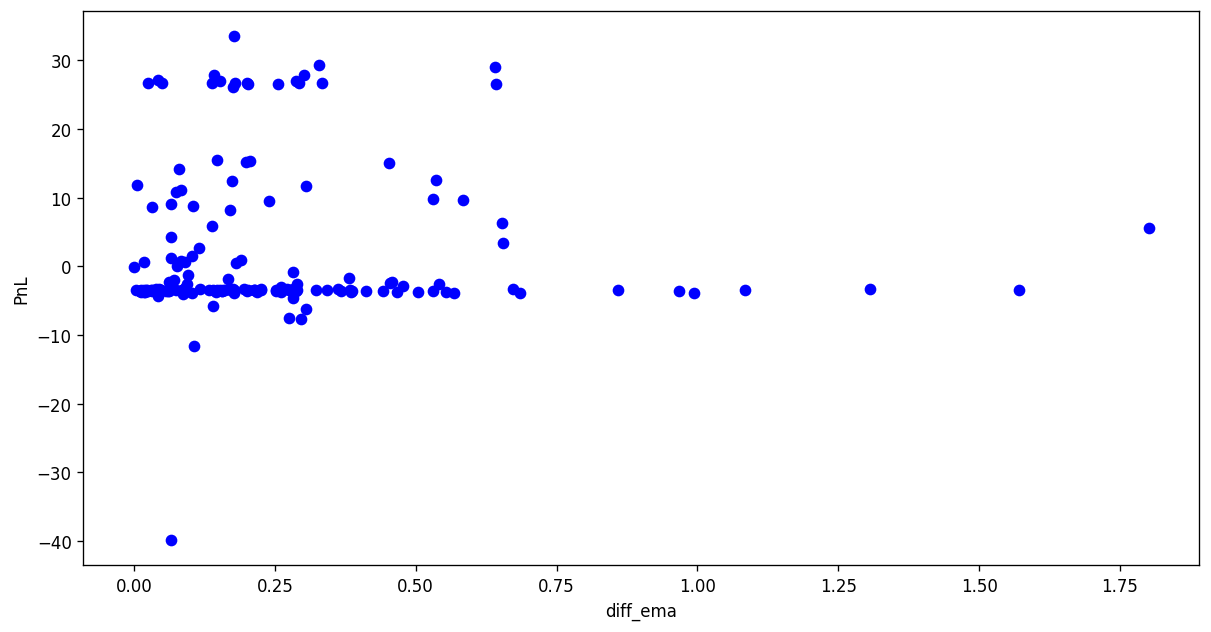

In [68]:
long_trades['diff_ema'] = long_trades['ema_fast'] - long_trades['ema_low']
plt.scatter(long_trades['diff_ema'], long_trades['PnL'], color='blue')
plt.xlabel("diff_ema")
plt.ylabel("PnL")

Text(0, 0.5, 'PnL')

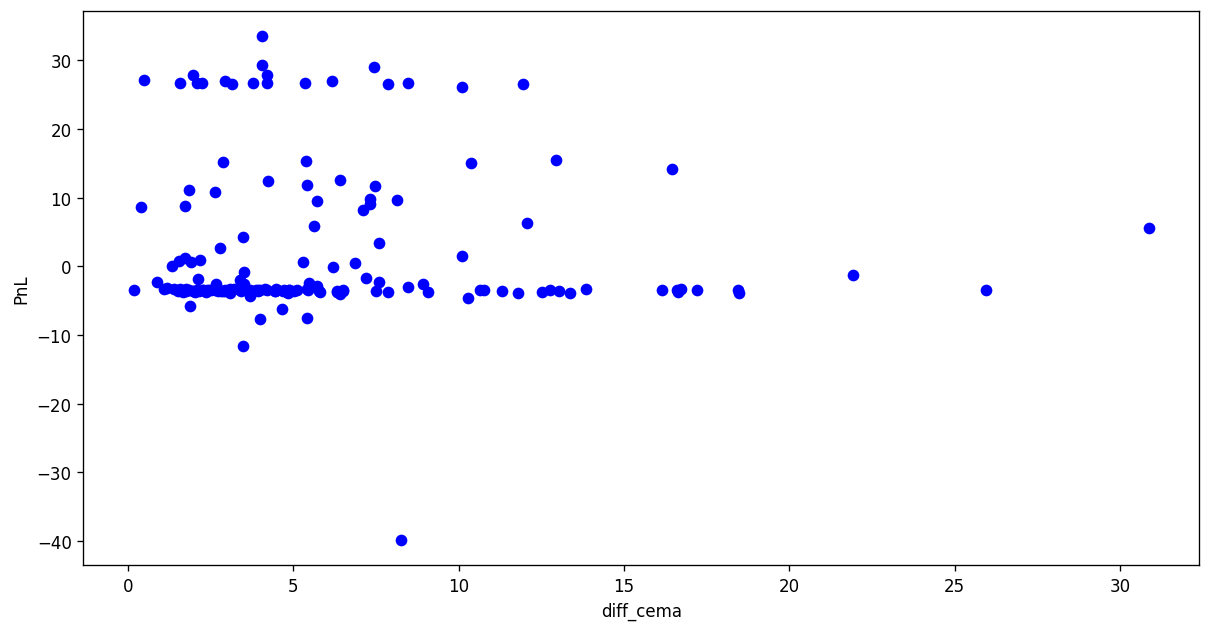

In [69]:
long_trades['diff_cema'] = long_trades['Close'] - long_trades['ema_low']
plt.scatter(long_trades['diff_cema'], long_trades['PnL'], color='blue')
plt.xlabel("diff_cema")
plt.ylabel("PnL")

Text(0, 0.5, 'PnL')

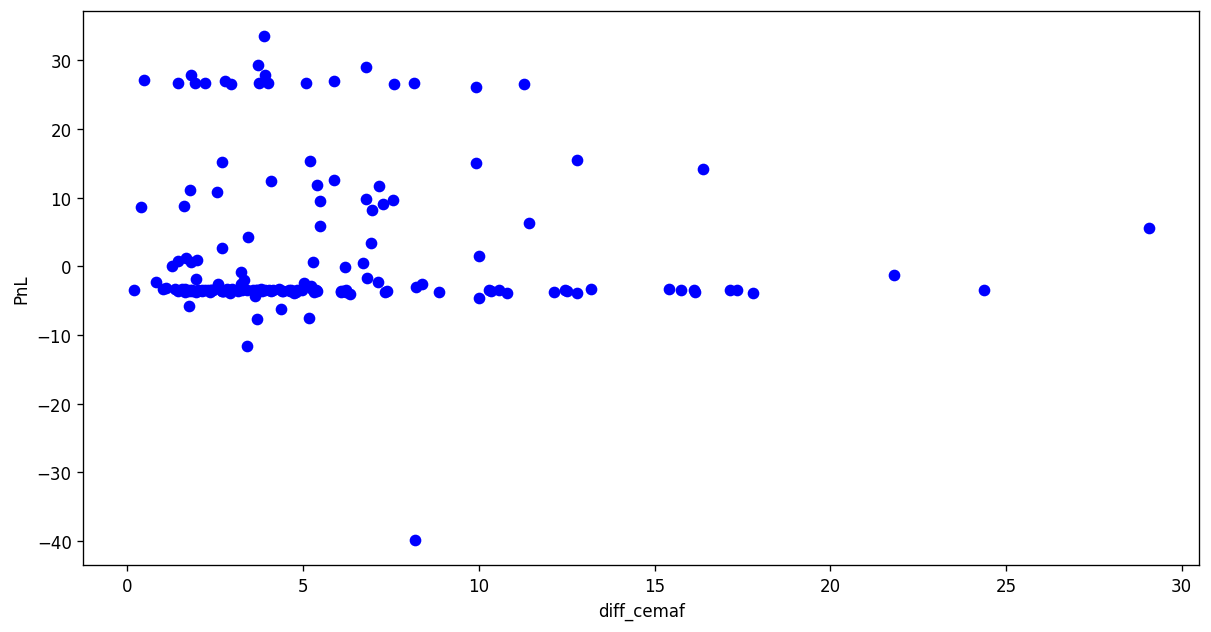

In [70]:
long_trades['diff_cemaf'] = long_trades['Close'] - long_trades['ema_fast']
plt.scatter(long_trades['diff_cemaf'], long_trades['PnL'], color='blue')
plt.xlabel("diff_cemaf")
plt.ylabel("PnL")

Text(0, 0.5, 'PnL')

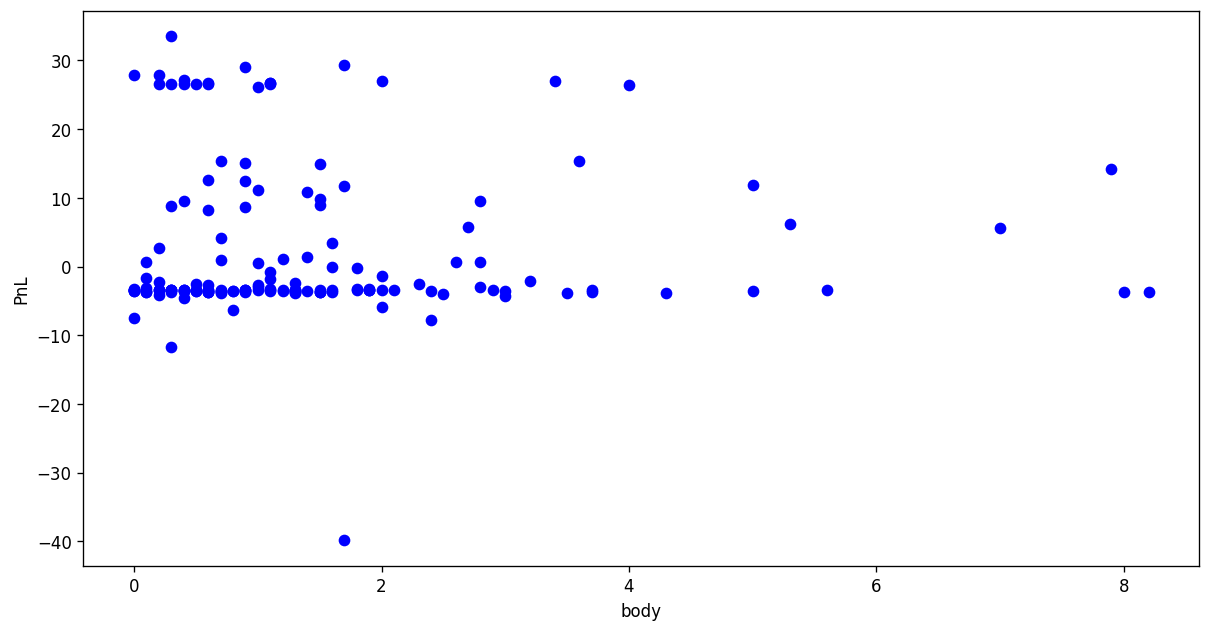

In [71]:
plt.scatter(long_trades['body'], long_trades['PnL'], color='blue')
plt.xlabel("body")
plt.ylabel("PnL")

Text(0, 0.5, 'PnL')

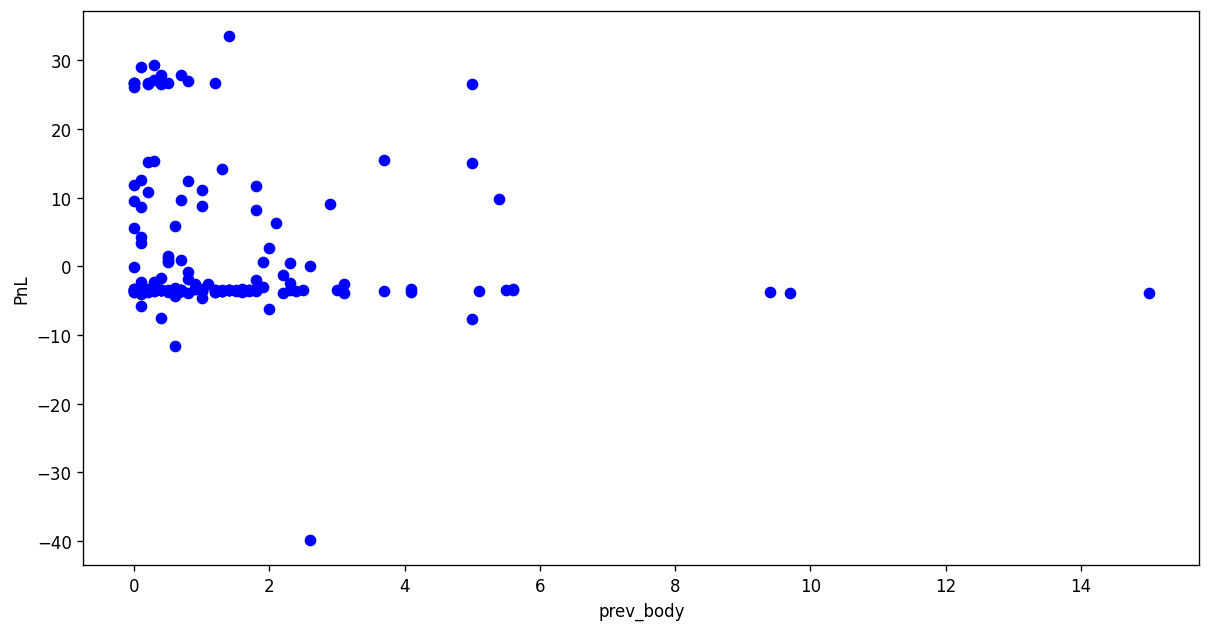

In [72]:
plt.scatter(long_trades['prev_body'], long_trades['PnL'], color='blue')
plt.xlabel("prev_body")
plt.ylabel("PnL")

Text(0, 0.5, 'PnL')

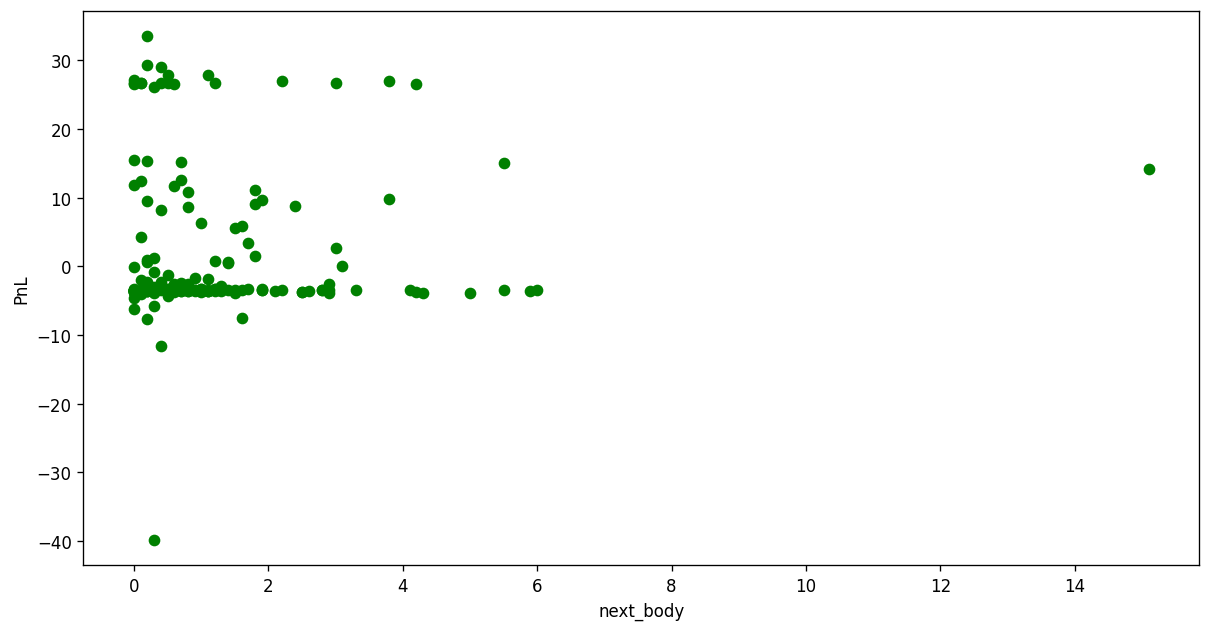

In [73]:
plt.scatter(long_trades['next_body'], long_trades['PnL'], color='green')
plt.xlabel("next_body")
plt.ylabel("PnL")

<Axes: xlabel='day_of_week'>

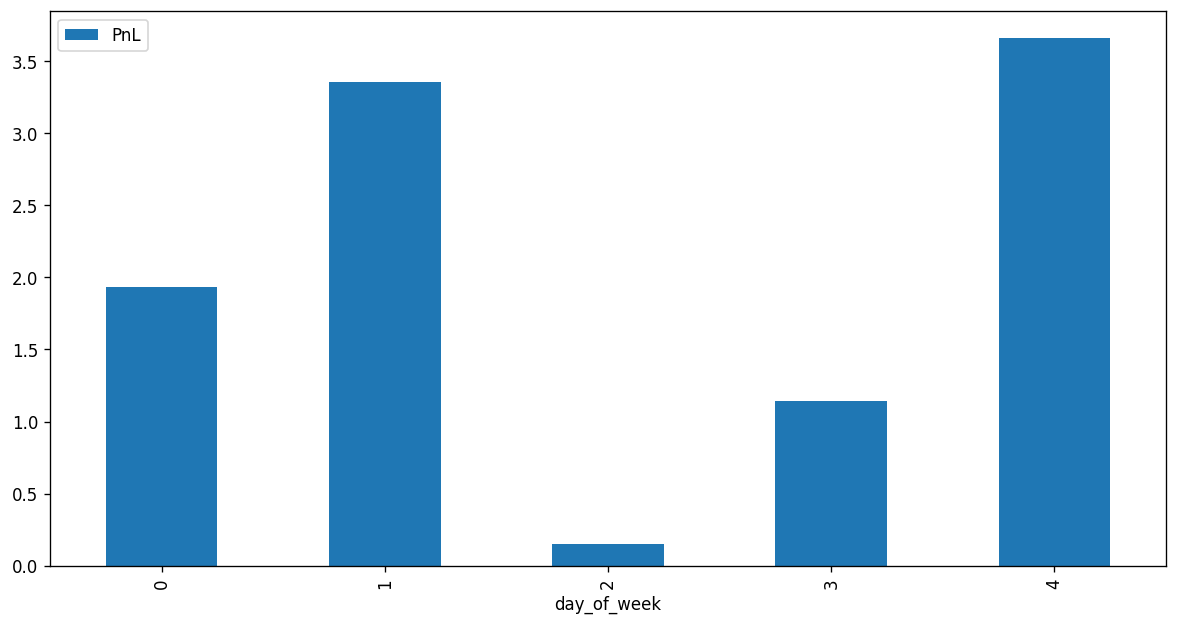

In [74]:
join_trades['day_of_week'] = join_trades['EntryTime'].dt.dayofweek
trades_grouped_by_dow = join_trades.groupby(['day_of_week'])[['PnL']].mean()
trades_grouped_by_dow.plot.bar()

<Axes: xlabel='day_of_week'>

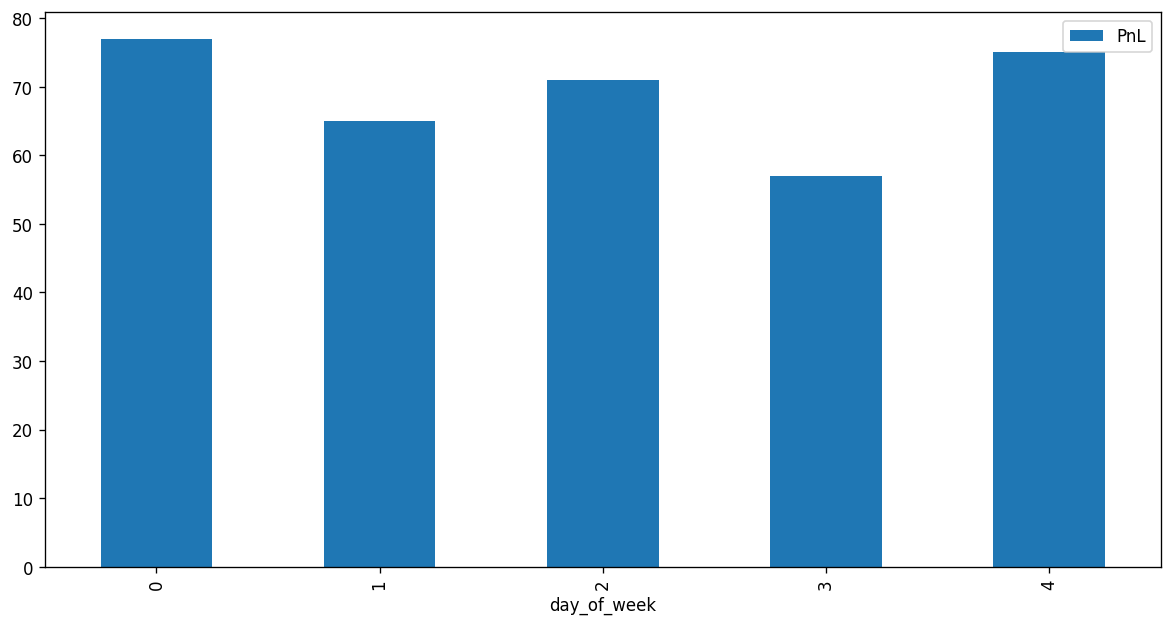

In [75]:
trades_grouped2_by_dow = join_trades.groupby(['day_of_week'])[['PnL']].count()
trades_grouped2_by_dow.plot.bar()

<Axes: xlabel='day_of_month'>

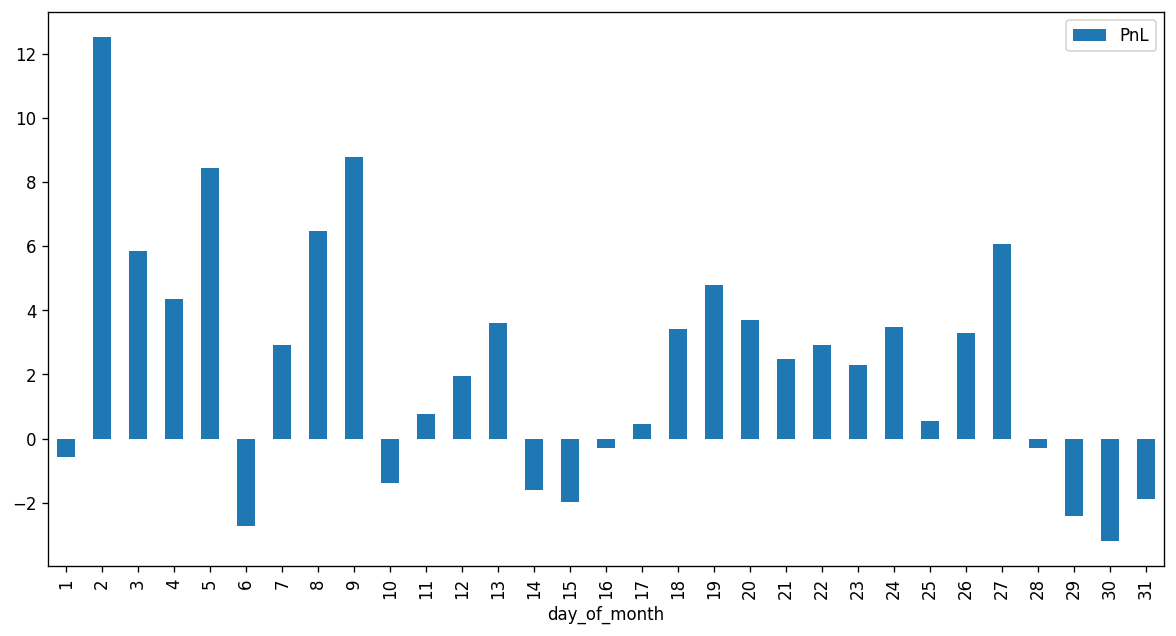

In [76]:
join_trades['day_of_month'] = join_trades['EntryTime'].dt.day
trades_grouped_by_dom = join_trades.groupby(['day_of_month'])[['PnL']].mean()
trades_grouped_by_dom.plot.bar()

<Axes: xlabel='day_of_month'>

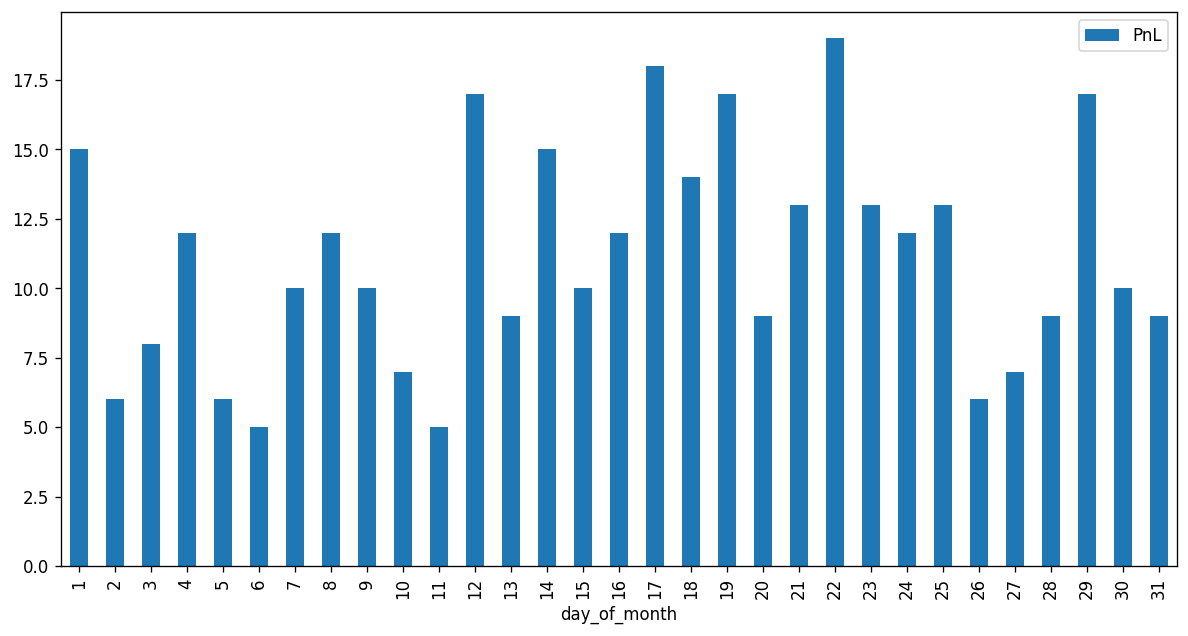

In [77]:
trades_grouped2_by_dom = join_trades.groupby(['day_of_month'])[['PnL']].count()
trades_grouped2_by_dom.plot.bar()

<Axes: xlabel='month'>

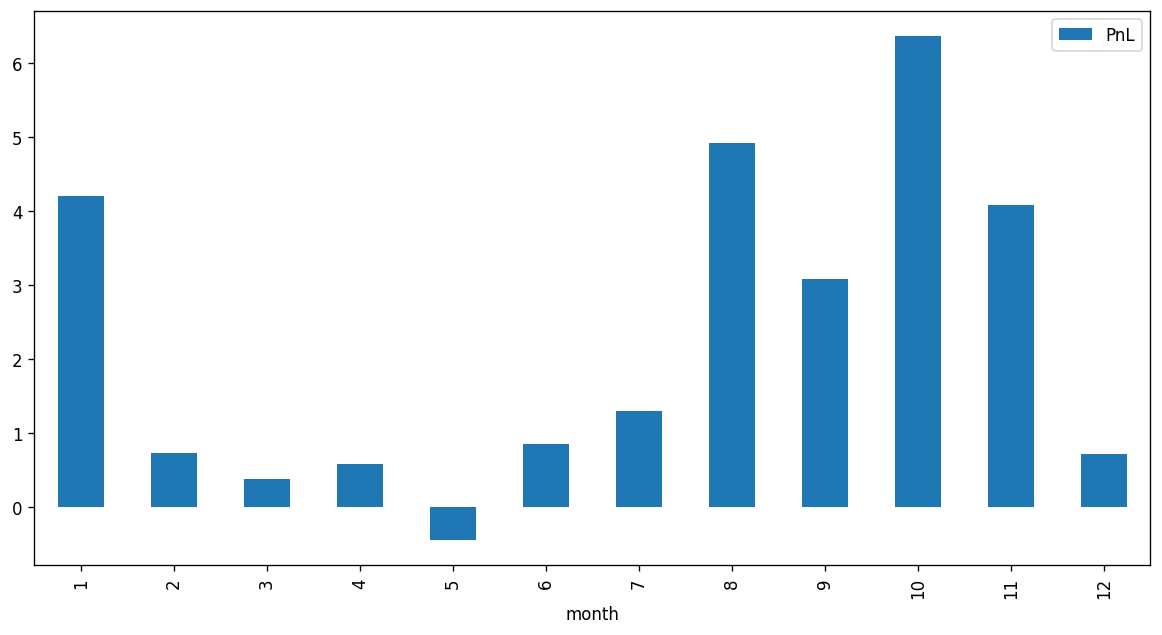

In [78]:
join_trades['month'] = join_trades['EntryTime'].dt.month
trades_grouped_by_month = join_trades.groupby(['month'])[['PnL']].mean()
trades_grouped_by_month.plot.bar()

<Axes: xlabel='month'>

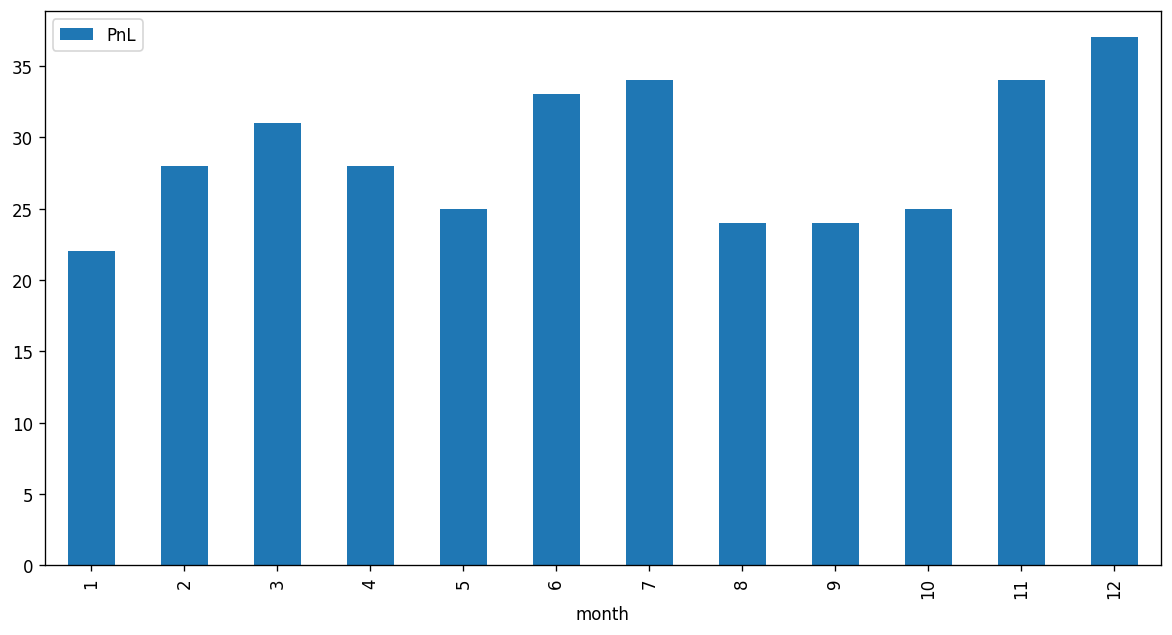

In [79]:
trades_grouped_by_monthc = join_trades.groupby(['month'])[['PnL']].count()
trades_grouped_by_monthc.plot.bar()

<Axes: xlabel='month'>

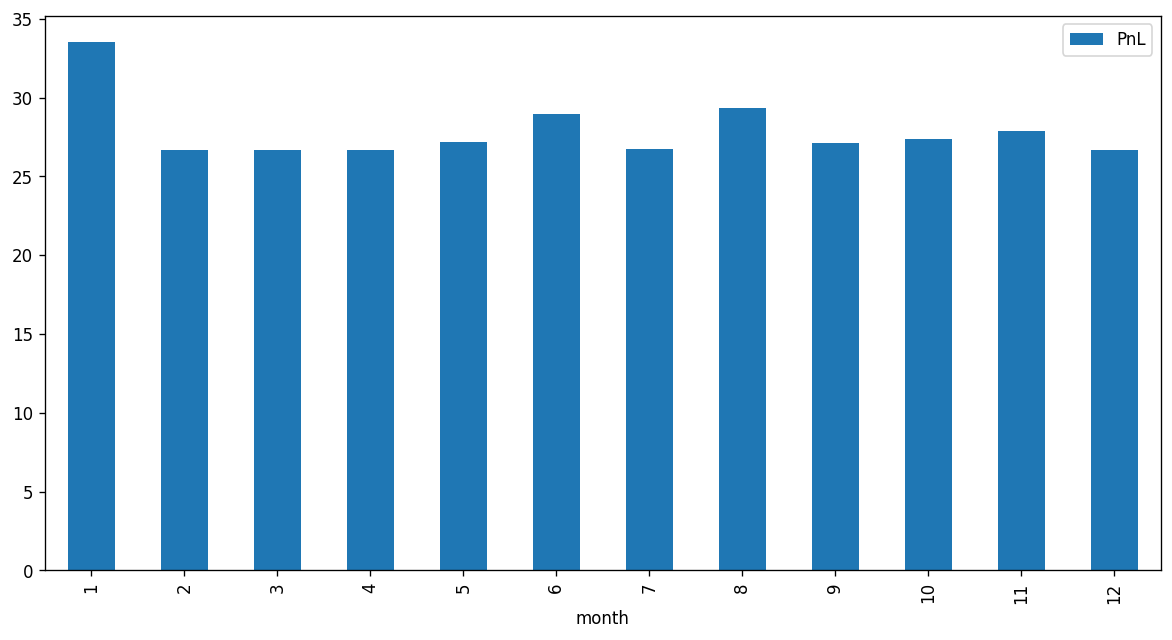

In [80]:
trades_grouped_by_monthma = join_trades.groupby(['month'])[['PnL']].max()
trades_grouped_by_monthma.plot.bar()

<Axes: xlabel='month'>

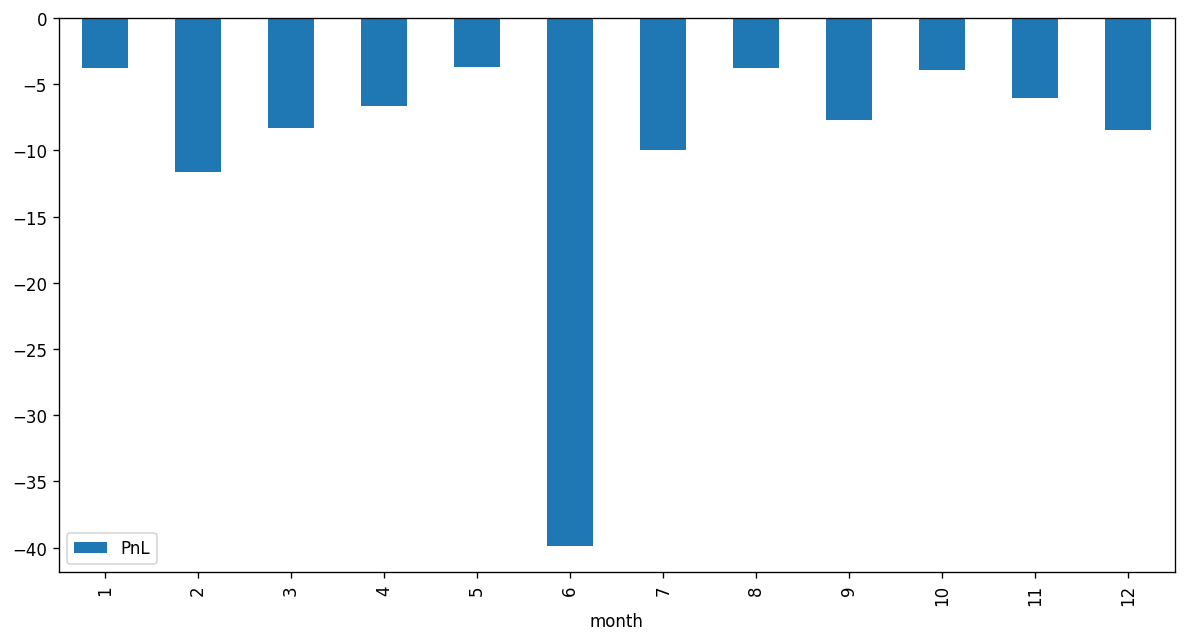

In [81]:
trades_grouped_by_monthmi = join_trades.groupby(['month'])[['PnL']].min()
trades_grouped_by_monthmi.plot.bar()

<Axes: xlabel='year'>

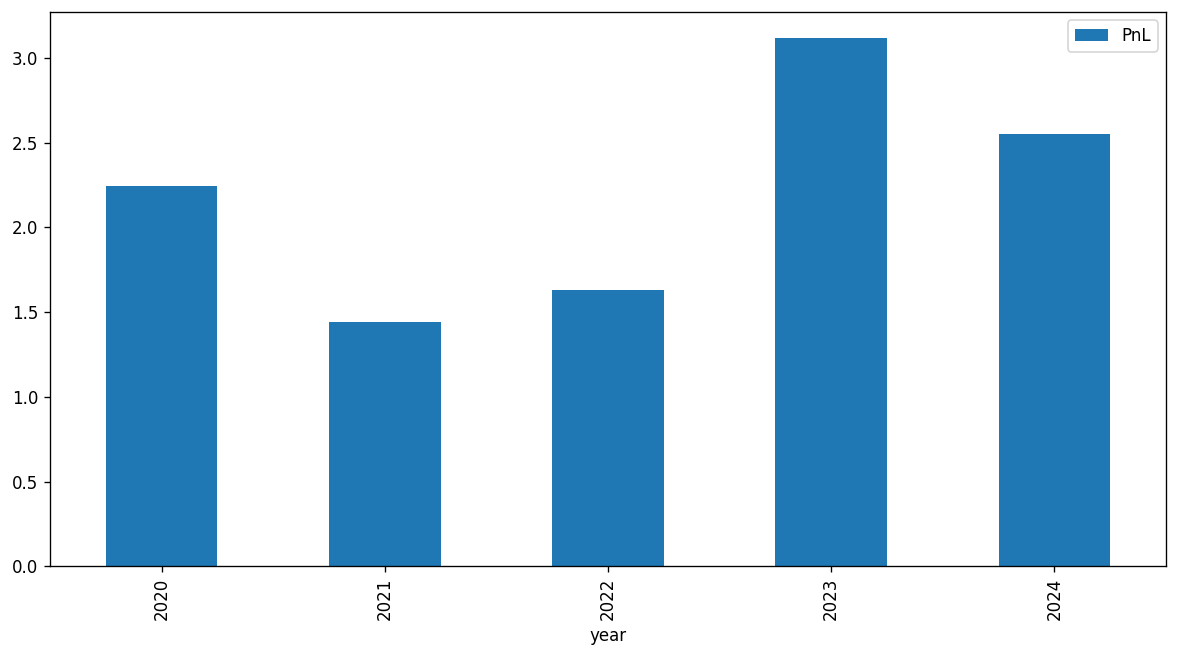

In [82]:
join_trades['year'] = join_trades['EntryTime'].dt.year
trades_grouped_by_year = join_trades.groupby(['year'])[['PnL']].mean()
trades_grouped_by_year.plot.bar()

## Optimize params

In [83]:
max_sl_params = [x / 10.0 for x in range(20, 50, 2)]
trailing_sl_params = [x / 10.0 for x in range(30, 100, 5)]
tp_step_params = [x for x in range(5, 35)]

In [84]:
trailing_sl_params

[3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5]

In [85]:
optimize_stats, optimize_table = bt.optimize(
                                      trailing_sl=trailing_sl_params,
                                      tp_step=tp_step_params,
                    maximize='Return [%]', 
                    random_state=0,
                    return_heatmap=True)

In [86]:
optimize_stats

Start                     2020-11-06 14:15:00
End                       2024-11-28 14:30:00
Duration                   1483 days 00:15:00
Exposure Time [%]                   26.200426
Equity Final [$]                   2308.23013
Equity Peak [$]                    2308.23013
Return [%]                          53.882009
Buy & Hold Return [%]                43.60861
Return (Ann.) [%]                   11.294634
Volatility (Ann.) [%]                6.134002
Sharpe Ratio                         1.841316
Sortino Ratio                        4.367257
Calmar Ratio                         1.488807
Max. Drawdown [%]                   -7.586366
Avg. Drawdown [%]                   -0.286262
Max. Drawdown Duration      248 days 19:40:00
Avg. Drawdown Duration        5 days 03:07:00
# Trades                                  345
Win Rate [%]                        29.275362
Best Trade [%]                        3.60858
Worst Trade [%]                     -3.099416
Avg. Trade [%]                    

In [87]:
optimize_table

trailing_sl  tp_step
3.0          5           2.438252
             6           4.616574
             7           8.708514
             8           9.251467
             9          10.141731
                          ...    
9.5          30         48.668675
             31         49.128675
             32         50.662009
             33         52.162009
             34         53.882009
Name: Return [%], Length: 420, dtype: float64

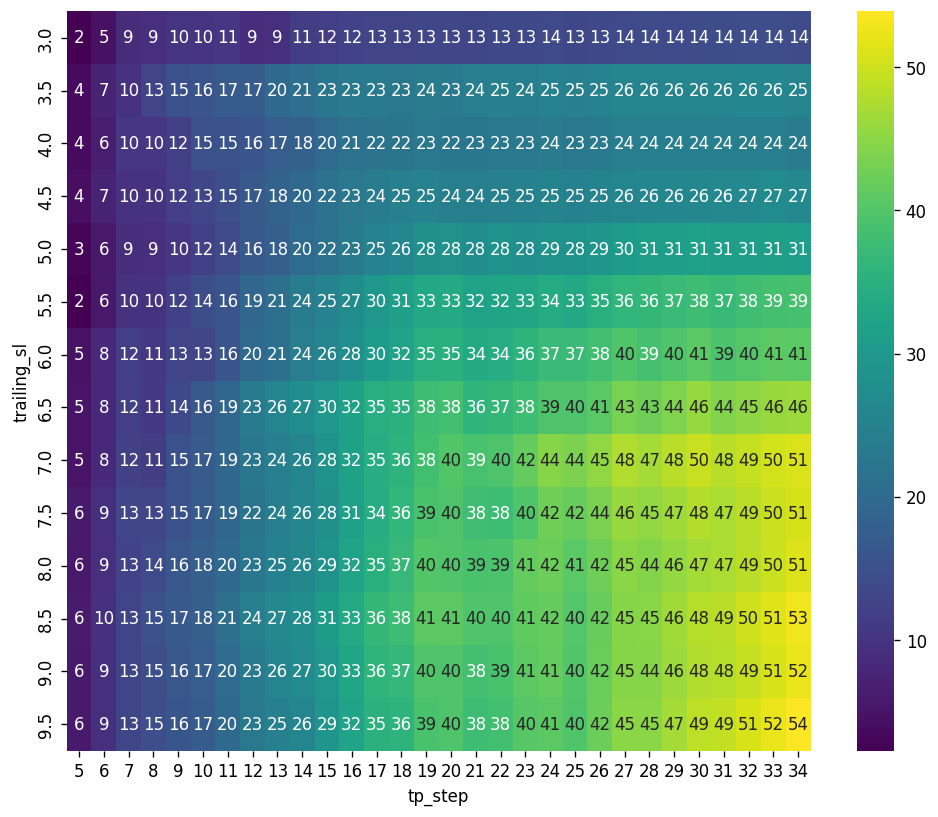

In [88]:
import seaborn as sns
# Convert multiindex series to dataframe
heatmap_df = optimize_table.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.0f')
plt.show()